### 0.2 Import Libraries 

a. viz libraries like matplotlib, seaborn etc.

b. DL framework like tf, keras etc.

In [ ]:
# Import common libraries
import os
import glob
import random
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import tensorflow and its modules
import tensorflow as tf
from tensorflow import keras # this allows <keras.> instead of <tf.keras.>
from tensorflow.keras import layers # this allows <layers.> instead of <tf.keras.layers.>
tf.keras.utils.set_random_seed(111) # set random seed

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class_dirs = os.listdir(r"D:\\tensorflow\\clothing-dataset-small\\clothing-dataset-small\\")
class_dirs

In [ ]:
for cls in class_dirs:
    print(cls)
    file_paths = glob.glob(f'D:\\tensorflow\\clothing-dataset-small\\clothing-dataset-small\\train{cls}/*')
    print(file_paths)

In [ ]:
class_dirs = os.listdir(r"D:\\tensorflow\\clothing-dataset-small\\clothing-dataset-small\\") # list all directories inside "train" folder
image_dict = {} # dict to store image array(key) for every class(value)
count_dict = {} # dict to store count of files(key) for every class(value)
# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'D:\\tensorflow\\clothing-dataset-small\\clothing-dataset-small\\{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    #image_dict[cls] = tf.keras.utils.load_img(image_path)

In [ ]:
## Viz Random Sample from each class
plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()):    
    # create a subplot axis
    ax = plt.subplot(3, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title 
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

- Notice that every Image has **different dimension!**
- This is expected in a real-world data, but can you guess why this is **not ideal**? Hint: Batching requires all samples to be of the same size!
- We will see later how we can handle this issue!

In [ ]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

# draw a bar plot using pandas in-built plotting function
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class") 

- Note that the `train/val/test` split already provided, we needn't create it explicitly!
- Also, we can observe that the data is **imbalanced**. For this lecture, we will work with the given data-distribution, but later on we will see some common techniques to work with imbalanced-data! (Any thoughts?)

## 2. Preprocessing

### Q. **What type of Preprocessing is required here?**  
  
- 2.1 Shape Preprocessing  
- 2.2 Value Preprocessing   
- 2.3 Additional Shape Preprocessing for MLPs

#### Before that, lets ***mount*** the data directory in Keras using [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) function

Keras provides a utility function (`tf.keras.utils.image_dataset_from_directory`) to directly load data from directory in `tf.data.Dataset` format.

In [ ]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\tensorflow\\clothing-dataset-small\\clothing-dataset-small\\train", shuffle = True,
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\tensorflow\\clothing-dataset-small\\clothing-dataset-small\\validation", shuffle = False,
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    "D:\\tensorflow\\clothing-dataset-small\\clothing-dataset-small\\test", shuffle = False,
)

In [ ]:
height, width = 240, 240 # Optional, not required if we already have resized the data from `image_dataset_from_directory` function.

# Data Processing Stage with resizing and rescaling operations
data_preprocess_with_flatten = keras.Sequential(
    name = "data_preprocess_with_flatten",
    layers = [
        layers.Resizing(height, width),
        layers.Rescaling(1./255),
        layers.Flatten(), # Note: We prefer NOT to add `layers.Flatten()` as part of preprocessing layers (rather as model definition itself)!
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess_with_flatten(x), y))

Let's visualize a sample after preprocessing:

In [ ]:
# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(height, width), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

In [ ]:
num_classes = 10
hidden_size_1 = 1024
hidden_size_2 = 256

model = keras.Sequential(
    name="model_ann",
    layers=[
        layers.Flatten(input_shape=(height, width, 3)), # alternatively, input_shape=next(iter(train_ds))[0].shape[1:]
        layers.Dense(units=hidden_size_1, activation='relu'), # hidden layer 1
        layers.Dense(units=hidden_size_2, activation='relu'), # hidden layer 2
        layers.Dense(units=num_classes, activation='softmax'), # output layer
    ]
)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, to_file="model_ann.png", show_shapes=True)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### 3.3 Training and Evaluation with Vanilla NN   

a. Let's train the model for 10 epochs

In [ ]:
epochs = 10
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax = axes.ravel()

#accuracy graph
ax[0].plot(range(0,model_fit.params['epochs']), [acc * 100 for acc in model_fit.history['accuracy']], label='Train', color='b')
ax[0].plot(range(0,model_fit.params['epochs']), [acc * 100 for acc in model_fit.history['val_accuracy']], label='Val', color='r')
ax[0].set_title('Accuracy vs. epoch', fontsize=15)
ax[0].set_ylabel('Accuracy', fontsize=15)
ax[0].set_xlabel('epoch', fontsize=15)
ax[0].legend()

#loss graph
ax[1].plot(range(0,model_fit.params['epochs']), model_fit.history['loss'], label='Train', color='b')
ax[1].plot(range(0,model_fit.params['epochs']), model_fit.history['val_loss'], label='Val', color='r')
ax[1].set_title('Loss vs. epoch', fontsize=15)
ax[1].set_ylabel('Loss', fontsize=15)
ax[1].set_xlabel('epoch', fontsize=15)
ax[1].legend()

#display the graph
plt.show()

In [34]:
# load model from pretrained checkpoints (optional)
#model.load_weights("/content/Saved Models/L1_ann_model.ckpt")

# run model prediction and obtain probabilities
y_pred = model.predict(test_ds)

# get list of predicted classes by taking argmax of the probabilities(y_pred)
predicted_categories = tf.argmax(y_pred, axis=1)

# get list of class names
class_names = test_data.class_names

# create list of all "y"s labels, by iterating over test dataset
true_categories = tf.concat([y for x, y in test_ds], axis=0)

# calculate accuracy
test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
print(f'\nTest Accuracy: {test_acc:.2f}%\n')

12/12 [==============================] - 1s 62ms/step

Test Accuracy: 36.83%



12/12 [==============================] - 1s 65ms/step


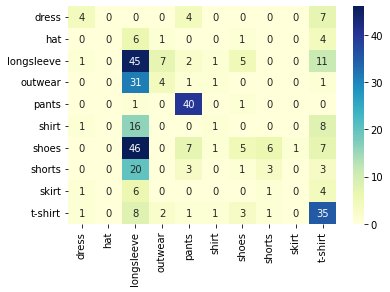

In [35]:
def ConfusionMatrix(model, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    # run model prediction and obtain probabilities
    y_pred = model.predict(ds)
    # get list of predicted classes by taking argmax of the probabilities(y_pred)
    predicted_categories = tf.argmax(y_pred, axis=1)
    # create list of all "y"s labels, by iterating over test dataset
    true_categories = tf.concat([y for x, y in ds], axis=0)
    # generate confusion matrix and plot it
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch 
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()

ConfusionMatrix(model, test_ds, test_data.class_names)

c. Let's also plot few samples from test set along with their predicted softmax probabilities.

- We plot the image and the predicted array (as bar plot) side-by-side.
- The predicted array is the class probabilities (output from softmax layer) corresponding to 10 classes.
- If the tallest bar (argmax) in the bar-plot is the true label, we color it blue else it's colored red. 
- Height of the bar plot indicates what's the probability of it predicting that label.

In [36]:
# function to plot image given image, its true label and class probabilities (pred_array)
def plot_image(pred_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(pred_array),
                                class_names[true_label]),
                                color=color)

# function to plot barplot of class probabilities (pred_array)
def plot_value_array(pred_array, true_label):
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), pred_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(pred_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

12/12 [==============================] - 1s 61ms/step


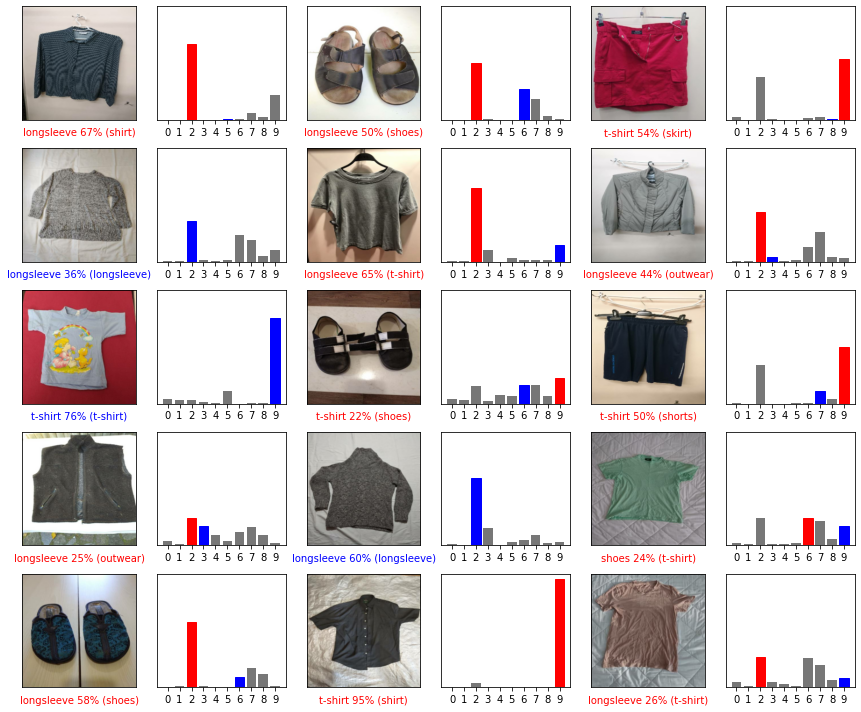

In [37]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
class_names = test_data.class_names

# Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
indices = random.sample(range(len(images)), 15)
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i,index in enumerate(indices):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(y_pred[index], true_categories[index], images[index])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(y_pred[index], true_categories[index])
plt.tight_layout()
plt.show()

In [54]:
num_classes = 10
hidden_size = 256

model = keras.Sequential(
    name="model_cnn",
    layers=[
        layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(units=hidden_size, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax')
    ]
)

In [55]:
tf.keras.utils.plot_model(model, to_file="model_cnn.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [56]:
model.summary()

Model: "model_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 240, 240, 256)     7168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 120, 120, 256)    0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 128)     295040    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 60, 60, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 64)       0 

b. Compile the model with **cross-entropy** loss and **adam** optimizer:

In [57]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### 3.5 Training and Evaluation with CNNs

a. Training for same 10 epochs

In [58]:
epochs = 10
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
96/96 [==============================] - 583s 6s/step - loss: 2.0708 - accuracy: 0.2950 - val_loss: 1.8269 - val_accuracy: 0.3519
Epoch 2/10
96/96 [==============================] - 573s 6s/step - loss: 1.4127 - accuracy: 0.5359 - val_loss: 1.2248 - val_accuracy: 0.5894
Epoch 3/10
96/96 [==============================] - 593s 6s/step - loss: 1.0716 - accuracy: 0.6463 - val_loss: 1.1786 - val_accuracy: 0.5894
Epoch 4/10
96/96 [==============================] - 39997s 421s/step - loss: 0.8646 - accuracy: 0.7119 - val_loss: 1.1051 - val_accuracy: 0.6422
Epoch 5/10
96/96 [==============================] - 511s 5s/step - loss: 0.7264 - accuracy: 0.7539 - val_loss: 1.2093 - val_accuracy: 0.6452
Epoch 6/10
96/96 [==============================] - 516s 5s/step - loss: 0.5476 - accuracy: 0.8162 - val_loss: 1.1996 - val_accuracy: 0.6569
Epoch 7/10
96/96 [==============================] - 522s 5s/step - loss: 0.4693 - accuracy: 0.8442 - val_loss: 1.5885 - val_accuracy: 0.6334
Epoch 8/1

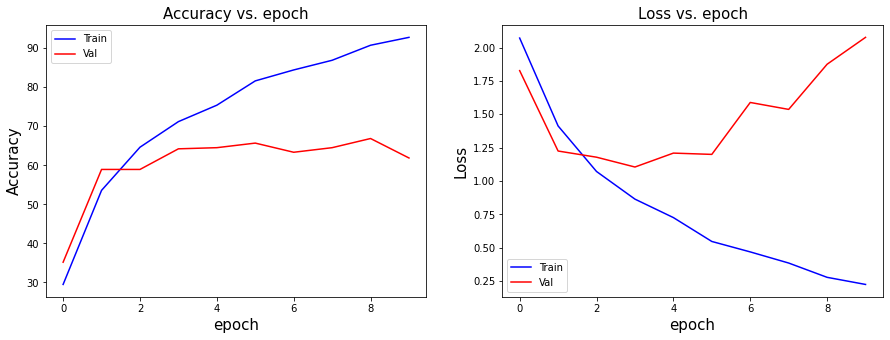

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
ax = axes.ravel()

#accuracy graph
ax[0].plot(range(0,model_fit.params['epochs']), [acc * 100 for acc in model_fit.history['accuracy']], label='Train', color='b')
ax[0].plot(range(0,model_fit.params['epochs']), [acc * 100 for acc in model_fit.history['val_accuracy']], label='Val', color='r')
ax[0].set_title('Accuracy vs. epoch', fontsize=15)
ax[0].set_ylabel('Accuracy', fontsize=15)
ax[0].set_xlabel('epoch', fontsize=15)
ax[0].legend()

#loss graph
ax[1].plot(range(0,model_fit.params['epochs']), model_fit.history['loss'], label='Train', color='b')
ax[1].plot(range(0,model_fit.params['epochs']), model_fit.history['val_loss'], label='Val', color='r')
ax[1].set_title('Loss vs. epoch', fontsize=15)
ax[1].set_ylabel('Loss', fontsize=15)
ax[1].set_xlabel('epoch', fontsize=15)
ax[1].legend()

#display the graph
plt.show()

c. Evaluation on Test Dataset  

Print Classification Report, Confusion Matrix and plot a few samples (with their probabilities)!

In [60]:
# load model from pretrained checkpoints (optional)
#model.load_weights("/content/Saved Models/L1_cnn_model.ckpt")

true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
class_names = test_data.class_names
predicted_categories = tf.argmax(y_pred, axis=1)

test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
print(f'\nTest Accuracy: {test_acc:.2f}%\n')

12/12 [==============================] - 15s 1s/step

Test Accuracy: 56.45%



12/12 [==============================] - 15s 1s/step


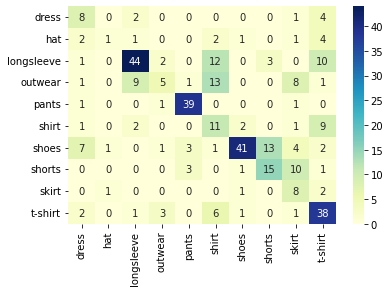

In [61]:
ConfusionMatrix(model, test_ds, test_data.class_names)

12/12 [==============================] - 16s 1s/step


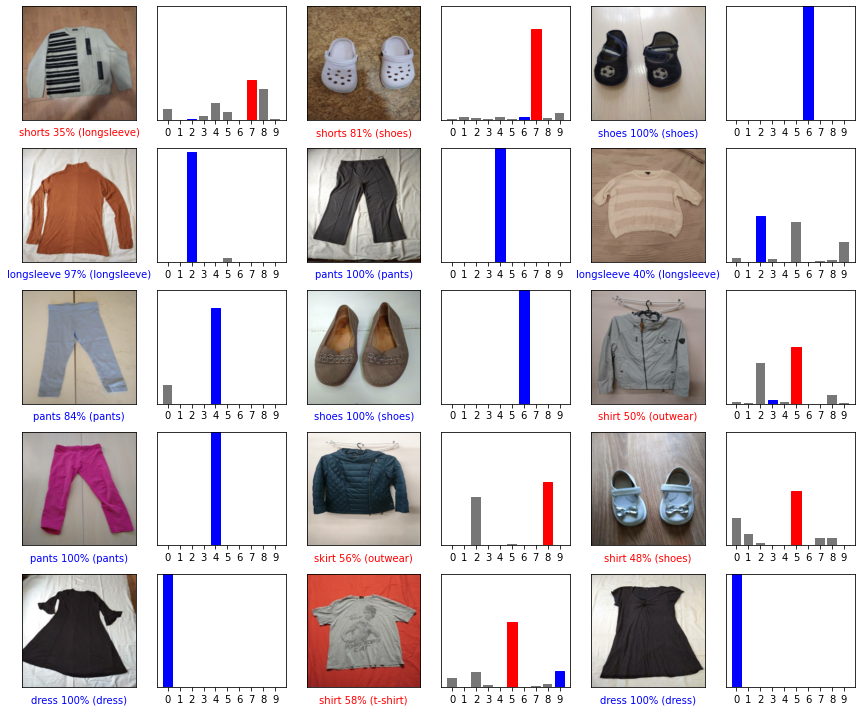

In [62]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
class_names = test_data.class_names

# Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
indices = random.sample(range(len(images)), 15)
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i,index in enumerate(indices):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(y_pred[index], true_categories[index], images[index])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(y_pred[index], true_categories[index])
plt.tight_layout()
plt.show()

In [63]:
num_classes = 10
hidden_size = 256

model = keras.Sequential(
    name="model_cnn",
    layers=[
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(units=hidden_size, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax')
    ]
)

In [65]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
epochs = 10
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
96/96 [==============================] - 47s 479ms/step - loss: 1.8002 - accuracy: 0.4231 - val_loss: 2.2064 - val_accuracy: 0.2581
Epoch 2/10
96/96 [==============================] - 55s 572ms/step - loss: 1.0996 - accuracy: 0.6362 - val_loss: 2.1519 - val_accuracy: 0.3431
Epoch 3/10
96/96 [==============================] - 56s 581ms/step - loss: 0.7591 - accuracy: 0.7477 - val_loss: 1.9064 - val_accuracy: 0.3754
Epoch 4/10
96/96 [==============================] - 59s 609ms/step - loss: 0.5437 - accuracy: 0.8171 - val_loss: 1.3710 - val_accuracy: 0.5894
Epoch 5/10
96/96 [==============================] - 57s 593ms/step - loss: 0.3742 - accuracy: 0.8742 - val_loss: 1.1462 - val_accuracy: 0.6452
Epoch 6/10
96/96 [==============================] - 56s 580ms/step - loss: 0.2466 - accuracy: 0.9179 - val_loss: 1.1818 - val_accuracy: 0.6891
Epoch 7/10
96/96 [==============================] - 58s 605ms/step - loss: 0.1908 - accuracy: 0.9345 - val_loss: 1.5863 - val_accuracy: 0.7009

In [71]:
# the above experiment using batch normalizing, batch normalize speed up the training time becuasse of its nature of normalizing the data in each layer. 
#the validation accuracy is 74.78% @ 9 epoch

In [67]:
num_classes = 10
hidden_size = 256

model = keras.Sequential(
    name="model_cnn",
    layers=[
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.BatchNormalization(),
        layers.Conv2D(filters=64, kernel_size=1, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.Conv2D(filters=64, kernel_size=1, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(units=hidden_size, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax')
    ]
)

In [68]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [69]:
epochs = 10
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
96/96 [==============================] - 43s 444ms/step - loss: 1.8824 - accuracy: 0.4136 - val_loss: 2.1594 - val_accuracy: 0.3490
Epoch 2/10
96/96 [==============================] - 50s 516ms/step - loss: 1.1472 - accuracy: 0.6183 - val_loss: 1.8888 - val_accuracy: 0.4194
Epoch 3/10
96/96 [==============================] - 52s 534ms/step - loss: 0.8459 - accuracy: 0.7252 - val_loss: 1.6348 - val_accuracy: 0.4311
Epoch 4/10
96/96 [==============================] - 55s 567ms/step - loss: 0.6367 - accuracy: 0.7846 - val_loss: 1.2654 - val_accuracy: 0.5572
Epoch 5/10
96/96 [==============================] - 53s 554ms/step - loss: 0.4747 - accuracy: 0.8390 - val_loss: 1.3889 - val_accuracy: 0.5924
Epoch 6/10
96/96 [==============================] - 54s 563ms/step - loss: 0.3244 - accuracy: 0.8918 - val_loss: 1.1020 - val_accuracy: 0.6686
Epoch 7/10
96/96 [==============================] - 51s 532ms/step - loss: 0.1921 - accuracy: 0.9381 - val_loss: 1.2414 - val_accuracy: 0.6657

In [70]:
# the above experiment using 1*1 convolution just before flattening opeation give "66% accuracy"post 10 epoch